# Calculating Gradient Models + Filter Inversion Closure
$$\tau_{ij} = \overline{u_iu}_j - \overline{u}_i \overline{u}_j$$ 
$$  \sigma_{i} = \overline{u_i\omega} - \overline{u}_i\overline{\omega}$$
$$\Pi_{\omega} = \nabla \cdot \sigma $$

$$\tau_{ij}^{\text{GM}} = \frac{1}{1!}\frac{\Delta^2}{12} \left( \frac{\partial \overline{u}_i}{\partial x_k} \frac{\partial \overline{u}_j}{\partial x_k}  \right) + 
\frac{1}{2!}\frac{\Delta^4}{12^2}
\left(\frac{\partial^2 \overline{u}_i}{\partial x_k x_l}\frac{\partial^2 \overline{u}_j}{\partial x_k \partial x_l} \right) +
\frac{1}{3!}\frac{\Delta^6}{12^3}\left(\frac{\partial^3 \overline{u}_i}{\partial x_k \partial x_l \partial x_m }\frac{\partial^3 \overline{u}_j}{\partial x_k \partial x_l \partial x_m} \right)$$
\
Here, we compute the GM models and validate the code.

In [1]:
# Import necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.io import loadmat
import jax
jax.config.update("jax_enable_x64", True)

# Importing custom modules 
from py2d.filter import filter2D
from py2d.SGSterms import Tau, Sigma, PiOmega, PiUV
from py2d.convert import Omega2Psi, Psi2UV
from py2d.initialize import initialize_wavenumbers_rfft2
from py2d.gradient_model import TauGM2, TauGM4, TauGM6, SigmaGM2, SigmaGM4, SigmaGM6, PiOmegaGM2, PiOmegaGM4, PiOmegaGM6, Tau_invert, Sigma_invert, PiOmega_invert

# Assuming Omega_DNS is provided and is 2D_matrix
# Assuming Kx and Ky are provided

# Define parameters 
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'
Lx = 2 * np.pi
N_LES = 128*np.ones(2, dtype=int)
Delta = 2*Lx/N_LES[0]

dealias = False

# Select FilterType: Gaussian or Box
filter_arr = ['gaussian', 'box']
coarseGrain = 'spectral'

# Load the data from the file
data = loadmat(filename)
# Extract the Omega data from the file
Omega_DNS = data['Omega']

# Initialize wavenumbers
Kx, Ky, Ksq, _, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')
Psi_DNS = Omega2Psi(Omega_DNS, invKsq)
U_DNS, V_DNS = Psi2UV(Psi_DNS, Kx, Ky)

if coarseGrain == 'spectral':
    Kx_coarse, Ky_coarse, Ksq_coarse, _, _ = initialize_wavenumbers_rfft2(N_LES[0], N_LES[1], Lx, Lx, INDEXING='ij')
elif coarseGrain == None:
    Kx_coarse, Ky_coarse, Ksq_coarse, _, _ = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')


Validating the GM codes by calculating correlation and MSE between the FDNS (Truth) and GM models
$$\tau_{ij}, \sigma_i, \Pi_{\omega}$$

In [2]:
for filter in filter_arr:

    if filter == 'box':
        continue

    # Computing GMs

    Omegaf = filter2D(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=N_LES, spectral=False)
    Uf = filter2D(U_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=N_LES, spectral=False)
    Vf = filter2D(V_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=N_LES, spectral=False)


    Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Tau11GM2, Tau12GM2, Tau22GM2 = TauGM2(Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Tau11GM4, Tau12GM4, Tau22GM4 = TauGM4(Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Tau11GM6, Tau12GM6, Tau22GM6 = TauGM6(Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Tau11_invert, Tau12_invert, Tau22_invert = Tau_invert(Uf, Vf,  Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)

    Sigma1, Sigma2 = Sigma(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Sigma1GM2, Sigma2GM2 = SigmaGM2(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Sigma1GM4, Sigma2GM4 = SigmaGM4(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Sigma1GM6, Sigma2GM6 = SigmaGM6(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Sigma1_invert, Sigma2_invert = Sigma_invert(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)

    PiOmega_val = PiOmega(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=dealias)
    PiOmegaGM2_val = PiOmegaGM2(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    PiOmegaGM4_val = PiOmegaGM4(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    PiOmegaGM6_val = PiOmegaGM6(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    PiOmega_invert_val = PiOmega_invert(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Ksq_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)

    # Compute the correlation coefficient and the mean squared error

    # Tau
    corr_Tau11GM2, _ = pearsonr(Tau11.flatten(), Tau11GM2.flatten())
    corr_Tau12GM2, _ = pearsonr(Tau12.flatten(), Tau12GM2.flatten())
    corr_Tau22GM2, _ = pearsonr(Tau22.flatten(), Tau22GM2.flatten())

    corr_Tau11GM4, _ = pearsonr(Tau11.flatten(), Tau11GM4.flatten())
    corr_Tau12GM4, _ = pearsonr(Tau12.flatten(), Tau12GM4.flatten())
    corr_Tau22GM4, _ = pearsonr(Tau22.flatten(), Tau22GM4.flatten())

    corr_Tau11GM6, _ = pearsonr(Tau11.flatten(), Tau11GM6.flatten())
    corr_Tau12GM6, _ = pearsonr(Tau12.flatten(), Tau12GM6.flatten())
    corr_Tau22GM6, _ = pearsonr(Tau22.flatten(), Tau22GM6.flatten())

    corr_Tau11_invert, _ = pearsonr(Tau11.flatten(), Tau11_invert.flatten())
    corr_Tau12_invert, _ = pearsonr(Tau12.flatten(), Tau12_invert.flatten())
    corr_Tau22_invert, _ = pearsonr(Tau22.flatten(), Tau22_invert.flatten())

    MSE_Tau11GM2 = mean_squared_error(Tau11.flatten(), Tau11GM2.flatten())
    MSE_Tau12GM2 = mean_squared_error(Tau12.flatten(), Tau12GM2.flatten())
    MSE_Tau22GM2 = mean_squared_error(Tau22.flatten(), Tau22GM2.flatten())

    MSE_Tau11GM4 = mean_squared_error(Tau11.flatten(), Tau11GM4.flatten())
    MSE_Tau12GM4 = mean_squared_error(Tau12.flatten(), Tau12GM4.flatten())
    MSE_Tau22GM4 = mean_squared_error(Tau22.flatten(), Tau22GM4.flatten())

    MSE_Tau11GM6 = mean_squared_error(Tau11.flatten(), Tau11GM6.flatten())
    MSE_Tau12GM6 = mean_squared_error(Tau12.flatten(), Tau12GM6.flatten())
    MSE_Tau22GM6 = mean_squared_error(Tau22.flatten(), Tau22GM6.flatten())

    MSE_Tau11_invert = mean_squared_error(Tau11.flatten(), Tau11_invert.flatten())
    MSE_Tau12_invert = mean_squared_error(Tau12.flatten(), Tau12_invert.flatten())
    MSE_Tau22_invert = mean_squared_error(Tau22.flatten(), Tau22_invert.flatten())

    # Sigma
    corr_Sigma1GM2, _ = pearsonr(Sigma1.flatten(), Sigma1GM2.flatten())
    corr_Sigma2GM2, _ = pearsonr(Sigma2.flatten(), Sigma2GM2.flatten())

    corr_Sigma1GM4, _ = pearsonr(Sigma1.flatten(), Sigma1GM4.flatten())
    corr_Sigma2GM4, _ = pearsonr(Sigma2.flatten(), Sigma2GM4.flatten())

    corr_Sigma1GM6, _ = pearsonr(Sigma1.flatten(), Sigma1GM6.flatten())
    corr_Sigma2GM6, _ = pearsonr(Sigma2.flatten(), Sigma2GM6.flatten())

    corr_Sigma1_invert, _ = pearsonr(Sigma1.flatten(), Sigma1_invert.flatten())
    corr_Sigma2_invert, _ = pearsonr(Sigma2.flatten(), Sigma2_invert.flatten())

    MSE_Sigma1GM2 = mean_squared_error(Sigma1.flatten(), Sigma1GM2.flatten())
    MSE_Sigma2GM2 = mean_squared_error(Sigma2.flatten(), Sigma2GM2.flatten())

    MSE_Sigma1GM4 = mean_squared_error(Sigma1.flatten(), Sigma1GM4.flatten())
    MSE_Sigma2GM4 = mean_squared_error(Sigma2.flatten(), Sigma2GM4.flatten())

    MSE_Sigma1GM6 = mean_squared_error(Sigma1.flatten(), Sigma1GM6.flatten())
    MSE_Sigma2GM6 = mean_squared_error(Sigma2.flatten(), Sigma2GM6.flatten())

    MSE_Sigma1_invert = mean_squared_error(Sigma1.flatten(), Sigma1_invert.flatten())
    MSE_Sigma2_invert = mean_squared_error(Sigma2.flatten(), Sigma2_invert.flatten())

    # PiOmega

    corr_PiOmegaGM2, _ = pearsonr(PiOmega_val.flatten(), PiOmegaGM2_val.flatten())
    corr_PiOmegaGM4, _ = pearsonr(PiOmega_val.flatten(), PiOmegaGM4_val.flatten())
    corr_PiOmegaGM6, _ = pearsonr(PiOmega_val.flatten(), PiOmegaGM6_val.flatten())
    corr_PiOmega_invert, _ = pearsonr(PiOmega_val.flatten(), PiOmega_invert_val.flatten())

    MSE_PiOmegaGM2 = mean_squared_error(PiOmega_val.flatten(), PiOmegaGM2_val.flatten())
    MSE_PiOmegaGM4 = mean_squared_error(PiOmega_val.flatten(), PiOmegaGM4_val.flatten())
    MSE_PiOmegaGM6 = mean_squared_error(PiOmega_val.flatten(), PiOmegaGM6_val.flatten())
    MSE_PiOmega_invert = mean_squared_error(PiOmega_val.flatten(), PiOmega_invert_val.flatten())

    print('****************************************************************************************')
    print('******************************* ' + filter + ' filter **************************************')
    print('****************************************************************************************')

    # Print the results
    print('Calculate the correlations between the FDNS and GM2/4/6 SGS terms')

    print('Correlation coefficient between Tau11 and GM2, GM4, GM6, filter inversion: ', corr_Tau11GM2, corr_Tau11GM4, corr_Tau11GM6, corr_Tau11_invert)
    print('Mean squared error between Tau11 and GM2, GM4, GM6, filter inversion: ', MSE_Tau11GM2, MSE_Tau11GM4, MSE_Tau11GM6, MSE_Tau11_invert)
    print('Correlation coefficient between Tau12 and GM2, GM4, GM6, filter inversion: ', corr_Tau12GM2, corr_Tau12GM4, corr_Tau12GM6, corr_Tau12_invert)
    print('Mean squared error between Tau12 and GM2, GM4, GM6, filter inversion: ', MSE_Tau12GM2, MSE_Tau12GM4, MSE_Tau12GM6, MSE_Tau12_invert)
    print('Correlation coefficient between Tau22 and GM2, GM4, GM6, filter inversion: ', corr_Tau22GM2, corr_Tau22GM4, corr_Tau22GM6, corr_Tau22_invert)
    print('Mean squared error between Tau22 and GM2, GM4, GM6, filter inversion: ', MSE_Tau22GM2, MSE_Tau22GM4, MSE_Tau22GM6, MSE_Tau22_invert)

    print('#####')

    print('Correlation coefficient between Sigma1 and GM2, GM4, GM6, filter inversion: ', corr_Sigma1GM2, corr_Sigma1GM4, corr_Sigma1GM6, corr_Sigma1_invert)
    print('Mean squared error between Sigma1 and GM2, GM4, GM6, filter inversion: ', MSE_Sigma1GM2, MSE_Sigma1GM4, MSE_Sigma1GM6, MSE_Sigma1_invert)
    print('Correlation coefficient between Sigma2 and GM2, GM4, GM6, filter inversion: ', corr_Sigma2GM2, corr_Sigma2GM4, corr_Sigma2GM6, corr_Sigma2_invert)
    print('Mean squared error between Sigma2 and GM2, GM4, GM6, filter inversion: ', MSE_Sigma2GM2, MSE_Sigma2GM4, MSE_Sigma2GM6, MSE_Sigma2_invert)

    print('#####')

    print('Correlation coefficient between PiOmega and GM2, GM4, GM6, filter inversion: ', corr_PiOmegaGM2, corr_PiOmegaGM4, corr_PiOmegaGM6, corr_PiOmega_invert)
    print('Mean squared error between PiOmega and GM2, GM4, GM6, filter inversion: ', MSE_PiOmegaGM2, MSE_PiOmegaGM4, MSE_PiOmegaGM6, MSE_PiOmega_invert)

****************************************************************************************
******************************* gaussian filter **************************************
****************************************************************************************
Calculate the correlations between the FDNS and GM2/4/6 SGS terms
Correlation coefficient between Tau11 and GM2, GM4, GM6, filter inversion:  0.9958056553057418 0.9981564452984932 0.9983063170429869 0.9977608652629346
Mean squared error between Tau11 and GM2, GM4, GM6, filter inversion:  8.140871533768829e-07 3.1327169777135094e-07 2.799637359053696e-07 3.6628019359816147e-07
Correlation coefficient between Tau12 and GM2, GM4, GM6, filter inversion:  0.9951738103919008 0.9983929328690075 0.9986055195481092 0.9984270096322456
Mean squared error between Tau12 and GM2, GM4, GM6, filter inversion:  3.4048351125102893e-07 1.1193747340096131e-07 9.55808664026593e-08 1.0733028333387007e-07
Correlation coefficient between Tau22 and G

### Contours of GM Models

****************************************************************************************
******************************* gaussian filter **************************************
****************************************************************************************


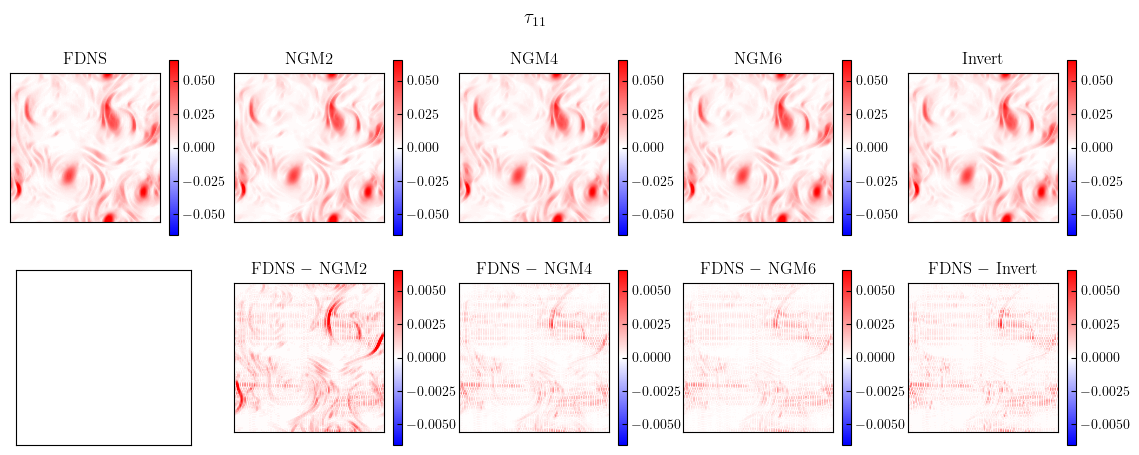

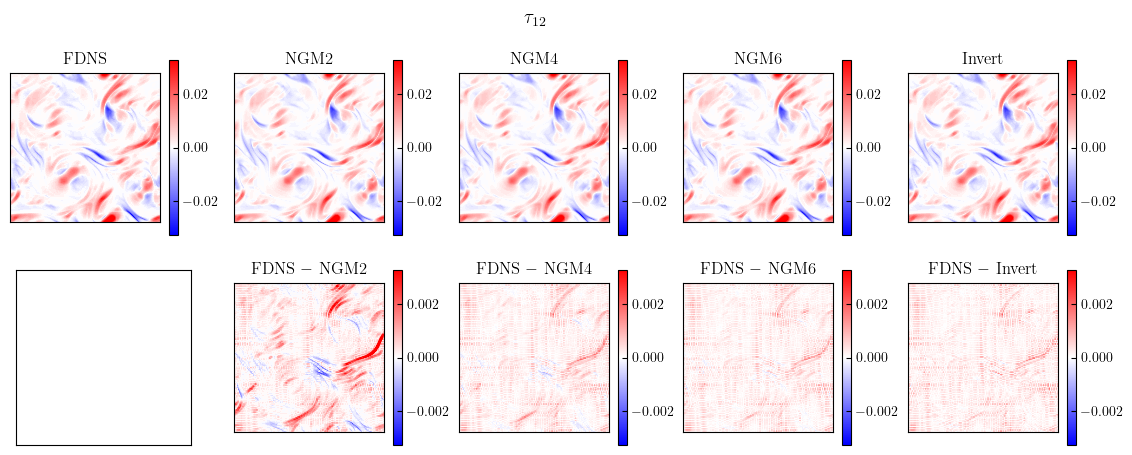

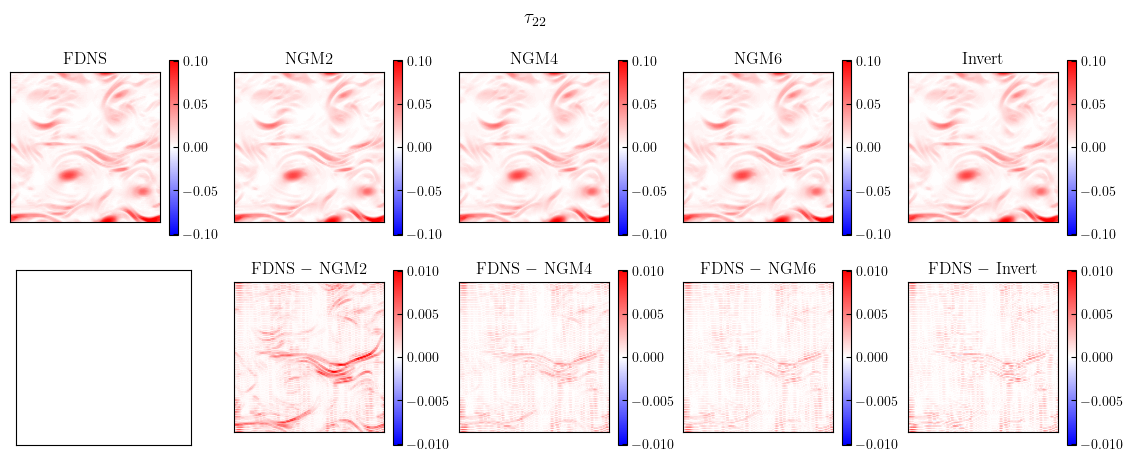

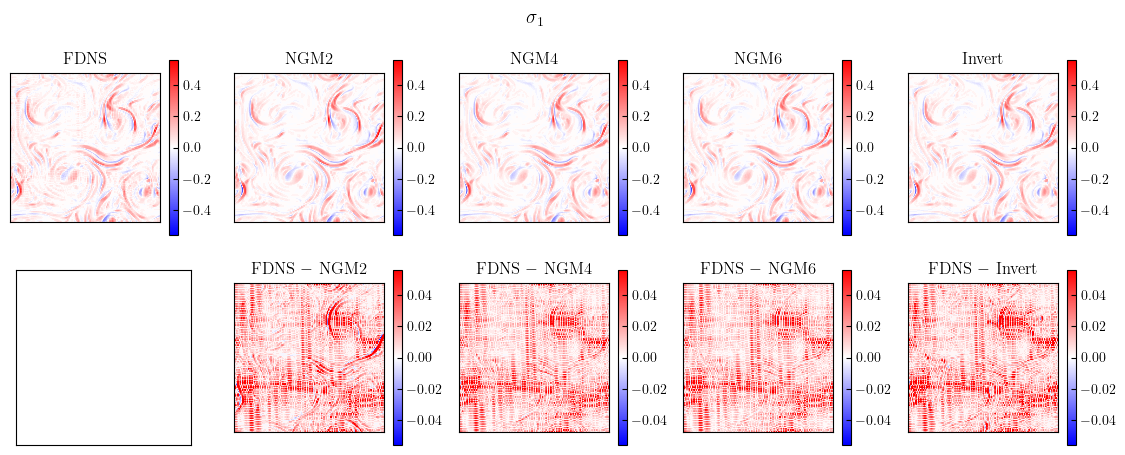

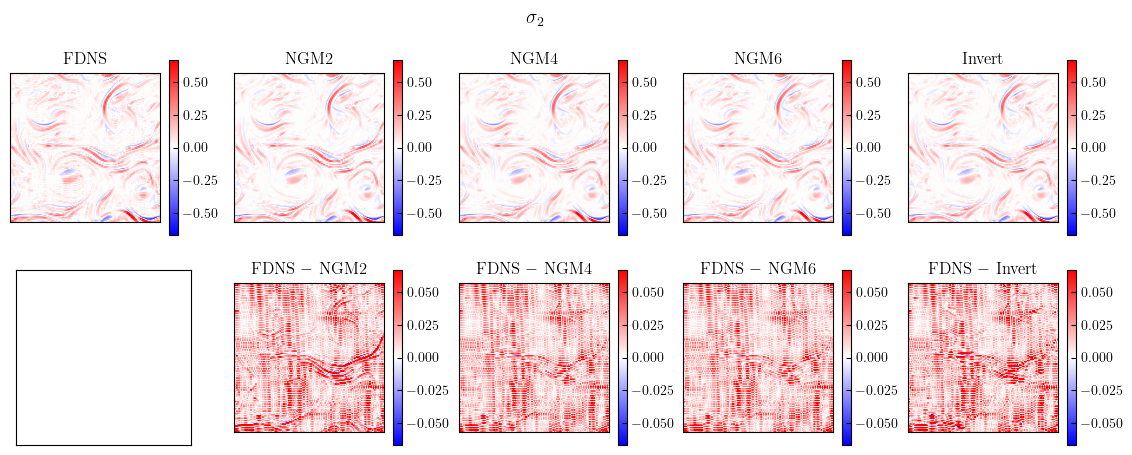

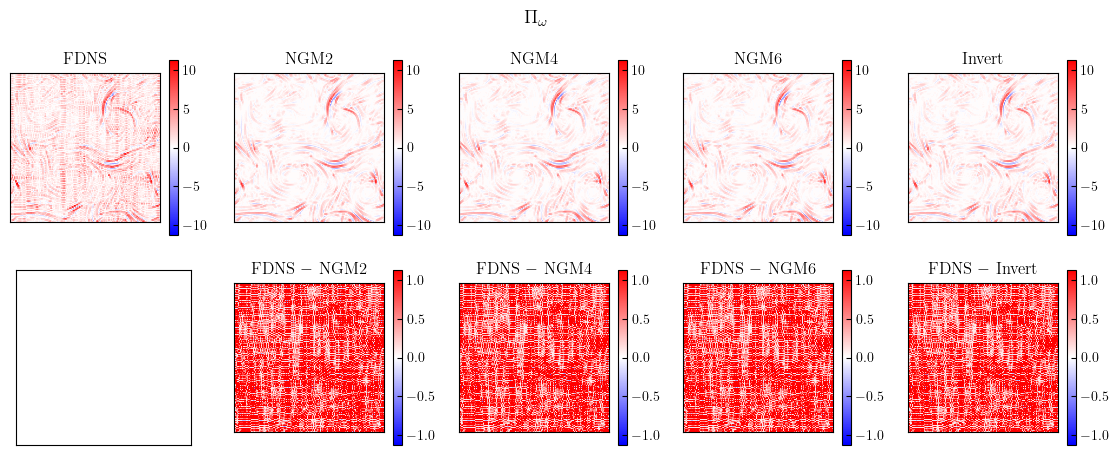

****************************************************************************************
******************************* box filter **************************************
****************************************************************************************


UnboundLocalError: local variable 'Tau11' referenced before assignment

In [3]:
import matplotlib.cm as cm

 # Set default properties
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

# Set default properties
params = {
    'text.usetex': True, # Use LaTeX to interpret text
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'cmu-serif',
    'figure.titlesize': BIGGER_SIZE,  # Title size
    'font.size': MEDIUM_SIZE,      # Default font size
    'lines.markersize': 5,       # Default line marker size
    'axes.titlesize': MEDIUM_SIZE,   # Title size
    'axes.labelsize': MEDIUM_SIZE,   
    'legend.fontsize': MEDIUM_SIZE,  # Legend font size 
    'xtick.direction': 'in',     # Ticks inside the panel
    'ytick.direction': 'in',     # Ticks inside the panel
    'xtick.labelsize': SMALL_SIZE,        # x-axis tick label size
    'ytick.labelsize': SMALL_SIZE,        # y-axis tick label size
}
plt.rcParams.update(params)

marker = ['-' , '-', '-', '-', '--', '--', '--']
colors = ['black', 'r', 'b', 'g', '#00CD6C', '#009ADE', '#FFC61E']


cntourLevels = 100

for filter in filter_arr:

    print('****************************************************************************************')
    print('******************************* ' + filter + ' filter **************************************')
    print('****************************************************************************************')

    # Computing GMs

    Omegaf = filter2D(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=N_LES, spectral=False)
    Uf = filter2D(U_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=N_LES, spectral=False)
    Vf = filter2D(V_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=N_LES, spectral=False)


    Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Tau11GM2, Tau12GM2, Tau22GM2 = TauGM2(Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Tau11GM4, Tau12GM4, Tau22GM4 = TauGM4(Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Tau11GM6, Tau12GM6, Tau22GM6 = TauGM6(Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Tau11_invert, Tau12_invert, Tau22_invert = Tau_invert(Uf, Vf,  Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)

    Sigma1, Sigma2 = Sigma(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Sigma1GM2, Sigma2GM2 = SigmaGM2(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Sigma1GM4, Sigma2GM4 = SigmaGM4(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Sigma1GM6, Sigma2GM6 = SigmaGM6(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    Sigma1_invert, Sigma2_invert = Sigma_invert(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)

    PiOmega_val = PiOmega(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=dealias)
    PiOmegaGM2_val = PiOmegaGM2(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    PiOmegaGM4_val = PiOmegaGM4(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    PiOmegaGM6_val = PiOmegaGM6(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)
    PiOmega_invert_val = PiOmega_invert(Omegaf, Uf, Vf, Kx_coarse, Ky_coarse, Ksq_coarse, Delta, filterType=filter, spectral=False, dealias=dealias)

    for SGSTerm in ['Tau11', 'Tau12', 'Tau22', 'Sigma1', 'Sigma2', 'PiOmega']:

        if SGSTerm == 'Tau11':
            FDNS = Tau11
            GM2 = Tau11GM2
            GM4 = Tau11GM4
            GM6 = Tau11GM6
            invert = Tau11_invert
            title = r'$\tau_{11}$'
        elif SGSTerm == 'Tau12':
            FDNS = Tau12
            GM2 = Tau12GM2
            GM4 = Tau12GM4
            GM6 = Tau12GM6
            invert = Tau12_invert
            title = r'$\tau_{12}$'
        elif SGSTerm == 'Tau22':
            FDNS = Tau22
            GM2 = Tau22GM2
            GM4 = Tau22GM4
            GM6 = Tau22GM6
            invert = Tau22_invert
            title = r'$\tau_{22}$'
        elif SGSTerm == 'Sigma1':
            FDNS = Sigma1
            GM2 = Sigma1GM2
            GM4 = Sigma1GM4
            GM6 = Sigma1GM6
            invert = Sigma1_invert
            title = r'$\sigma_{1}$'
        elif SGSTerm == 'Sigma2':
            FDNS = Sigma2
            GM2 = Sigma2GM2
            GM4 = Sigma2GM4
            GM6 = Sigma2GM6
            invert = Sigma2_invert
            title = r'$\sigma_{2}$'
        elif SGSTerm == 'PiOmega':
            FDNS = PiOmega_val
            GM2 = PiOmegaGM2_val
            GM4 = PiOmegaGM4_val
            GM6 = PiOmegaGM6_val
            invert = PiOmega_invert_val
            title = r'$\Pi_{\omega}$'

        fig, axs = plt.subplots(2, 5, figsize=(14, 5))
        plt.suptitle(title)

        vmax = 0.8*np.max(np.abs(FDNS))

        axs[0,0].contourf(FDNS, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[0, 0].set_title(r'FDNS')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[0,0])  # Create colorbar with label using ScalarMappable

        axs[0,1].contourf(GM2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[0, 1].set_title(r'NGM2')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[0,1])  # Create colorbar with label using ScalarMappable

        axs[0,2].contourf(GM4, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[0, 2].set_title(r'NGM4')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[0,2])  # Create colorbar with label using ScalarMappable

        axs[0,3].contourf(GM6, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[0, 3].set_title(r'NGM6')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[0,3])  # Create colorbar with label using ScalarMappable

        axs[0,4].contourf(invert, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[0, 4].set_title(r'Invert')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[0,4])

        vmax = 0.08*np.max(np.abs(FDNS))

        axs[1,1].contourf(FDNS-GM2, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[1,1].set_title(r'FDNS $-$ NGM2')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[1,1])  # Create colorbar with label using ScalarMappable

        axs[1,2].contourf(FDNS-GM4, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[1,2].set_title(r'FDNS $-$ NGM4')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[1,2])  # Create colorbar with label using ScalarMappable

        axs[1,3].contourf(FDNS-GM6, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[1,3].set_title(r'FDNS $-$ NGM6')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[1,3])  # Create colorbar with label using ScalarMappable

        axs[1,4].contourf(FDNS-invert, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
        axs[1,4].set_title(r'FDNS $-$ Invert')
        # colorbar
        sm = cm.ScalarMappable(cmap='bwr')
        sm.set_clim(vmin=-vmax, vmax=vmax)
        cbar = fig.colorbar(sm, ax=axs[1,4])

        for ax in np.ravel(axs):
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal', 'box')

        # plt.savefig('Tau12.png', dpi=300, bbox_inches='tight')
    plt.show()

5.287602459276684e-16


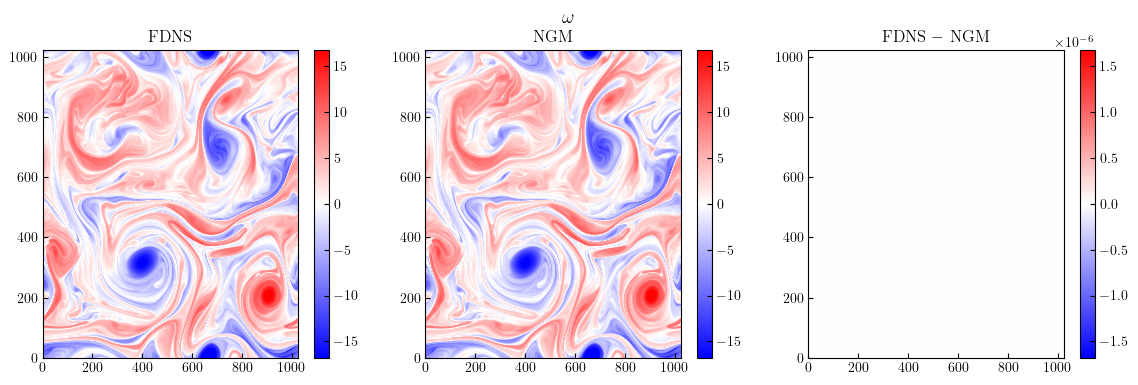

In [40]:
from py2d.filter import filter2D_gaussian_spectral_jit, invertFilter2D_gausian_spectral_jit, filter2D_box_spectral_jit, invertFilter2D_box_spectral_jit
import jax.numpy as jnp


nx = 1024
Kx, Ky, Ksq, _, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')

a = Omega_DNS

Omega_hat = jnp.fft.rfft2(a)
# Omegaf_hat = filter2D_gaussian_spectral_jit(Omega_hat, Ksq, Delta)
Omegaf_hat = filter2D_box_spectral_jit(Omega_hat, Kx,Ky, Delta)

# Omega_invert_hat = invertFilter2D_gausian_spectral_jit(Omegaf_hat, Ksq, Delta)
Omega_invert_hat = invertFilter2D_box_spectral_jit(Omegaf_hat, Kx,Ky, Delta)

Omega = jnp.fft.irfft2(Omega_hat)

# print max difference between Omega and Omega_DNS
print(jnp.max(jnp.abs(Omega - a))/jnp.max(jnp.abs(a)))



# plot contour of Omega_DNS and Omega and theri difference

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plt.suptitle(r'$\omega$')

vmax = 0.8*np.max(np.abs(Omega_DNS))

axs[0].contourf(Omega_DNS, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
axs[0].set_title(r'FDNS')
# colorbar
sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
sm.set_clim(vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(sm, ax=axs[0])  # Create colorbar with label using ScalarMappable

axs[1].contourf(Omega, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
axs[1].set_title(r'NGM')
# colorbar
sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
sm.set_clim(vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(sm, ax=axs[1])  # Create colorbar with label using ScalarMappable

vmax = 0.00000008*np.max(np.abs(Omega_DNS))

axs[2].contourf(Omega - Omega_DNS, cntourLevels, cmap='bwr', vmax=vmax, vmin=-vmax)
axs[2].set_title(r'FDNS $-$ NGM')
# colorbar
sm = cm.ScalarMappable(cmap='bwr')  # Create a ScalarMappable object
sm.set_clim(vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(sm, ax=axs[2])  # Create colorbar with label using ScalarMappable
